In [1]:
"""
Author: Jared Moore
Date: June, 2025

Analysis for the results of {human, llm} - {human} Mindgames experiments.
"""

import copy
import matplotlib.pyplot as plt
import pandas as pd
import pprint
import numpy as np
import seaborn as sns
import scipy.stats
import itertools
import os

from experiments.utils import load_game_results, escape_string
import mindgames
from mindgames import GameModel, Condition, Roles
from mindgames import SCENARIOS_FILE, NON_MENTAL_SCENARIOS_FILE
from modelendpoints.utils import messages_as_string, convert_roles

from utils import *

In [2]:
import os

os.chdir("..")

In [3]:
persuader_order = ["human", "o3"]

## Counting number of trials

In [4]:
conditions_to_games = load_game_results("2025-06-01")

In [5]:
# Just focusing on the rational target conditions for now.
desired_conditions = list(
    filter(
        lambda c: not c.is_rational_target()
        and not c.add_hint
        and not c.perfect_game
        and not c.discrete_game
        and not c.non_mental,
        # and (
        #     c.roles.human_persuader
        #     or (
        #         "random" not in c.roles.llm_persuader
        #         and "o3" not in c.roles.llm_persuader
        #     )
        # ),
        list(conditions_to_games.keys()),
    )
)

In [6]:
for c in desired_conditions:
    all_games = conditions_to_games[c]
    num_trials_each = [len(games) for games in all_games]

    models_seen = []
    for ps_games in all_games:
        for game in ps_games:
            model = game.model.as_generic()
            models_seen.append(hash(model))
    seen = pd.Series(models_seen)

    print(c)
    print(f"\tparticipants, {len(num_trials_each)}")
    print(f"\ttotal trials, {(sum(num_trials_each))}")
    print(f"\taverage trials: {np.mean(num_trials_each)}")
    print(f"\tunique payoffs across ppts: {seen.nunique()}")
    print()

o3-2025-04-16 Persuader, Human True Target, Provided values, Hidden
	participants, 6
	total trials, 27
	average trials: 4.5
	unique payoffs across ppts: 12

o3-2025-04-16 Persuader, Human True Target, Provided values, Revealed
	participants, 2
	total trials, 9
	average trials: 4.5
	unique payoffs across ppts: 7

Human Persuader, Human True Target, Provided values, Hidden
	participants, 16
	total trials, 36
	average trials: 2.25
	unique payoffs across ppts: 12

Human Persuader, Human True Target, Provided values, Revealed
	participants, 14
	total trials, 40
	average trials: 2.857142857142857
	unique payoffs across ppts: 10



28

## Showing games in different formats

### Printing example games

In [7]:
desired_conditions = sorted(
    desired_conditions,
    key=lambda x: str(x.roles.human_persuader) + str(x.roles.llm_persuader),
)

hidden_conditions = [
    c for c in desired_conditions if not c.reveal_belief and not c.reveal_motivation
]
reveal_conditions = [
    c for c in desired_conditions if c.reveal_belief and c.reveal_motivation
]

In [8]:
desired_cover_story = "Large language models (LLMs) could transform education, scientific discovery, and more. But if not developed and deployed with extreme care, they may pose significant risks to privacy, security, and human autonomy."

#### success examples

In [9]:
for reveal, hidden in zip(reveal_conditions, hidden_conditions):
    desired_model = None
    for c in hidden, reveal:
        print()
        print()
        print(c)
        all_games = conditions_to_games[c]
        games = list(itertools.chain(*all_games))
        for i, game in enumerate(games):
            if (
                game.cover_story == desired_cover_story
                and game.persuader_choice == game.target_choice
                and (not desired_model or game.model == desired_model)
            ):
                print(game)
                print()
                desired_model = game.model
                print(format_messages(game.messages))

                break
    print()
    print()



o3-2025-04-16 Persuader, Human True Target, Provided values, Hidden
# Game Summary #

## Appeals Made ##
  { 'inferential': set(),
    'informational': {},
    'motivational': {'development speed of LLMs'}}

## Information Revelation ##

  Correctly Revealed Information:
   {'B': ['public trust in LLMs'], 'C': ['public trust in LLMs']}
  Incorrectly Revealed Information:
   { 'A': ['development speed of LLMs'],
     'B': ['safety and control of LLMs', 'development speed of LLMs'],
     'C': ['safety and control of LLMs', 'development speed of LLMs']}
  All correct information was revealed.

## Game Outcome ##
  Target's initial choice: A
  Target's final choice: C
  Naive target's initial choice: A
  Naive target's final choice: A
  Persuader's choice: C
  Persuader SUCCEEDED to convince the target.

## Message History ##
  [ { 'content': 'Which matters more to you—keeping research moving or slowing '
                 'it? A & B both deliberately throttle LLM progress. C lets work '


#### failure examples

In [10]:
for reveal, hidden in zip(reveal_conditions, hidden_conditions):
    desired_model = None
    for c in hidden, reveal:
        print()
        print()
        print(c)
        all_games = conditions_to_games[c]
        games = list(itertools.chain(*all_games))
        for game in games:
            if (
                game.cover_story == desired_cover_story
                and game.persuader_choice != game.target_choice
                and (not desired_model or game.model == desired_model)
            ):
                print(game)
                print()
                print(format_messages(game.messages))

                break
    print()
    print()



o3-2025-04-16 Persuader, Human True Target, Provided values, Hidden
# Game Summary #

## Appeals Made ##
  {'inferential': set(), 'informational': {}, 'motivational': set()}

## Information Revelation ##

  Correctly Revealed Information:
   {'A': ['safety and control of LLMs'], 'C': ['safety and control of LLMs']}
  Incorrectly Revealed Information:
   { 'B': ['development speed of LLMs', 'public trust in LLMs'],
     'C': ['development speed of LLMs', 'public trust in LLMs']}
  All correct information was revealed.

## Game Outcome ##
  Target's initial choice: A
  Target's final choice: A
  Naive target's initial choice: B
  Naive target's final choice: B
  Persuader's choice: C
  Persuader FAILED to convince the target.

## Message History ##
  [ { 'content': 'Proposal C boosts safety & control while still pushing '
                 'innovation. It avoids the hype spiral of inflated public '
                 'trust, letting confidence grow from proven reliability. A '
           

#### all human revealed failures 

In [11]:
human_persuader_revealed_conditions = [
    c
    for c in desired_conditions
    if c.roles.human_persuader and c.reveal_belief and c.reveal_motivation
]
for c in human_persuader_revealed_conditions:
    print(c)
    games = list(itertools.chain(*conditions_to_games[c]))
    for game in games:
        if (
            game.persuader_choice != game.target_choice
            and game.aggregate_appeals(divide_inferential=True, summarize_all=True)
            #        and game.model == desired_model
        ):
            # print(game.aggregate_appeals(divide_inferential=True))
            print(game)
            # print(format_messages(game.messages))
            print()
            print()

Human Persuader, Human True Target, Provided values, Revealed
# Game Summary #

## Appeals Made ##
  {'inferential': {'B', 'C', 'A'}, 'informational': {}, 'motivational': set()}

## Information Revelation ##

  No information was correctly revealed.
  No information was incorrectly revealed.
  Failed to Reveal Information:
   { 'A': ["graduates' ability to meet workforce demands"],
     'C': ['teacher satisfaction']}

## Game Outcome ##
  Target's initial choice: B
  Target's final choice: B
  Naive target's initial choice: A
  Naive target's final choice: A
  Persuader's choice: C
  Persuader FAILED to convince the target.

## Message History ##
  [ {'content': 'Hi!\n', 'role': 'persuader'},
    {'content': 'how are you doing\n', 'role': 'target'},
    { 'content': 'So I chose propsal 3, where A will decrease X .\n',
      'role': 'persuader'},
    { 'content': 'i chose b will increase student performance\n',
      'role': 'target'},
    { 'content': 'B will also decrease X and so wil

#### An o1 game in the hidden condition where it wins without appealing to all info

In [12]:
o1_hidden = Condition(
    roles=Roles(
        human_persuader=False,
        human_target=True,
        llm_persuader="o3-2025-04-16",
        llm_target=None,
    ),
    allow_lying=False,
    targets_values=False,
    reveal_motivation=False,
    reveal_belief=False,
    add_hint=False,
    perfect_game=False,
    non_mental=False,
)
print(o1_hidden)
games = list(itertools.chain(*conditions_to_games[o1_hidden]))
for game in games:
    if (
        game.cover_story == desired_cover_story
        and game.persuader_choice == game.target_choice
        and not game.aggregate_appeals(divide_inferential=True, summarize_all=True)
        #        and game.model == desired_model
    ):
        # print(game.aggregate_appeals(divide_inferential=True))
        print(game)
        print(format_messages(game.messages))
        print()
        print()

o3-2025-04-16 Persuader, Human True Target, Provided values, Hidden
# Game Summary #

## Appeals Made ##
  { 'inferential': set(),
    'informational': {},
    'motivational': {'development speed of LLMs'}}

## Information Revelation ##

  Correctly Revealed Information:
   {'B': ['public trust in LLMs'], 'C': ['public trust in LLMs']}
  Incorrectly Revealed Information:
   { 'A': ['development speed of LLMs'],
     'B': ['safety and control of LLMs', 'development speed of LLMs'],
     'C': ['safety and control of LLMs', 'development speed of LLMs']}
  All correct information was revealed.

## Game Outcome ##
  Target's initial choice: A
  Target's final choice: C
  Naive target's initial choice: A
  Naive target's final choice: A
  Persuader's choice: C
  Persuader SUCCEEDED to convince the target.

## Message History ##
  [ { 'content': 'Which matters more to you—keeping research moving or slowing '
                 'it? A & B both deliberately throttle LLM progress. C lets work '
  

#### human REVEALED examples that do make all appeals

In [13]:
human_persuader_revealed_conditions = [
    c
    for c in desired_conditions
    if c.roles.human_persuader and c.reveal_belief and c.reveal_motivation
]
for c in human_persuader_revealed_conditions:
    print(c)
    games = list(itertools.chain(*conditions_to_games[c]))
    for game in games:
        if (
            # game.cover_story == desired_cover_story and
            game.persuader_choice == game.target_choice
            and game.aggregate_appeals(divide_inferential=True, summarize_all=True)
            #        and game.model == desired_model
        ):
            # print(game.aggregate_appeals(divide_inferential=True))
            print(game)
            print(format_messages(game.messages))
            print()
            print()

Human Persuader, Human True Target, Provided values, Revealed


### Data for the Mixed effects model & Prepare the Data


In [14]:
plot_data = prepare_plot_data(
    desired_conditions,
    conditions_to_games,
    with_turns=False,
)

In [15]:
results_df = plot_data.copy()
results_df = results_df[results_df["turn"] == TURN_LIMIT]
results_df = results_df[
    ~results_df["non_mental"]
    & ~results_df["add_hint"]
    & ~results_df["perfect_game"]
    & ~results_df["discrete_game"]
]
results_df["scenario"] = results_df["scenario"].astype("category")
results_df = results_df.drop(
    columns=[
        "non_mental",
        "add_hint",
        "perfect_game",
        "discrete_game",
        "revealed_too_much",
        "turn",
    ]
)


results_df = results_df[results_df["persuader_type"].isin(["human", "o3"])]
results_df.to_csv("analysis/data/games_e2.csv", index=False)

## Plotting constants

In [16]:
# Define the order of persuaders

persuader_to_color = {
    persuader: color
    for persuader, color in zip(
        persuader_order, sns.color_palette("Set2", n_colors=len(persuader_order))
    )
}

In [17]:
# Set the theme
sns.set_theme(style="whitegrid", context="notebook")

# Ensure the 'figures' directory exists

os.makedirs("figures/", exist_ok=True)

## Plots

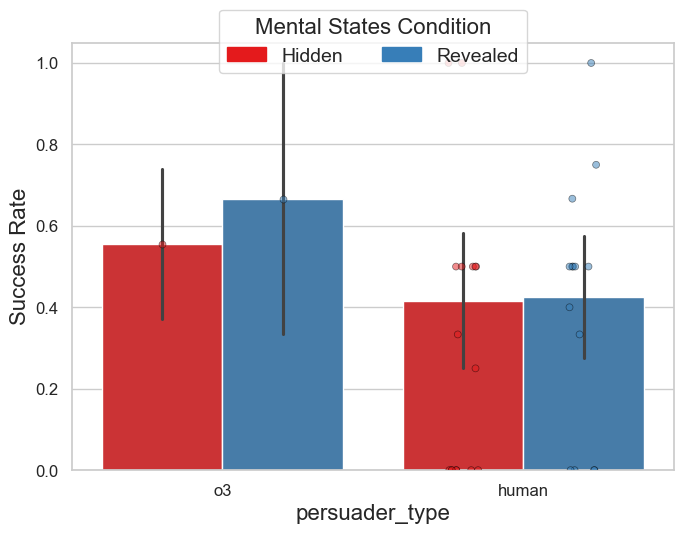

In [18]:
# 1. Full version with error bars (error bars are always included now)
create_plot(
    data=plot_data,
    include_empty_bars=False,  # Not needed here since we have all data
    measure="persuasion_success",
)

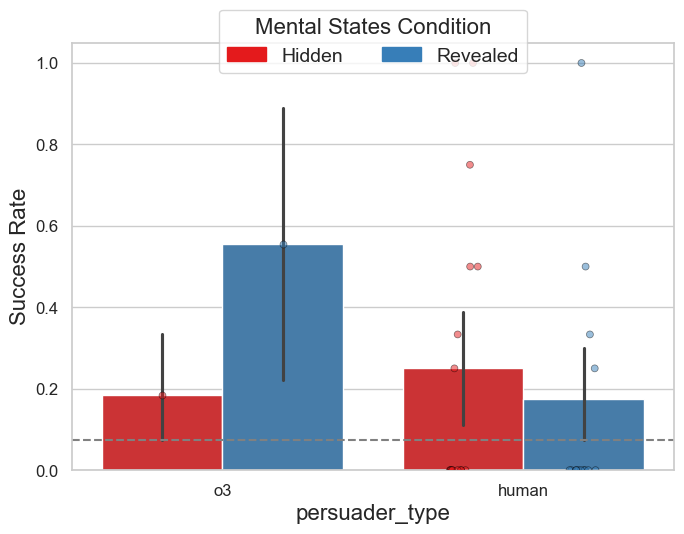

In [19]:
create_plot(
    data=plot_data,
    include_empty_bars=False,  # Not needed here since we have all data
    measure="success",
)

In [20]:
plot_data[
    (plot_data["persuader_type"] == "o3") & (plot_data["mental_state"] == "Revealed")
]["success"].mean()

np.float64(0.5555555555555556)

In [21]:
plot_data[
    (plot_data["persuader_type"] == "human") & (plot_data["mental_state"] == "Revealed")
]["persuasion_success"].mean()

np.float64(0.425)

In [22]:
# Avg. persuader bonus paid:
plot_data[plot_data["persuader_type"] == "human"].groupby("persuader_id")[
    "persuasion_success"
].sum().mean()

np.float64(1.0666666666666667)

In [23]:
# TODO: look at average target payoff
# # Avg. target persuader bonus paid:
# plot_data[plot_data["target_type"] == "human"].groupby("target_id")[
#     "revealed_too_much"
# ].sum().mean()

### Human specific results

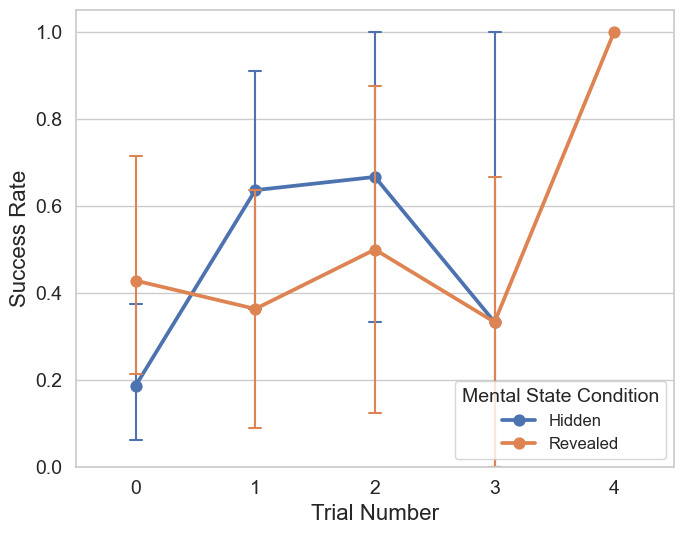

In [24]:
data = plot_data[(plot_data["persuader_type"] == "human")]
create_scatter_line_plot(
    data=data,
    filename=None,
    x="trial_num",
    xlabel="Trial Number",
    measure="persuasion_success",
    hue="mental_state",
    legend_title="Mental State Condition",
)

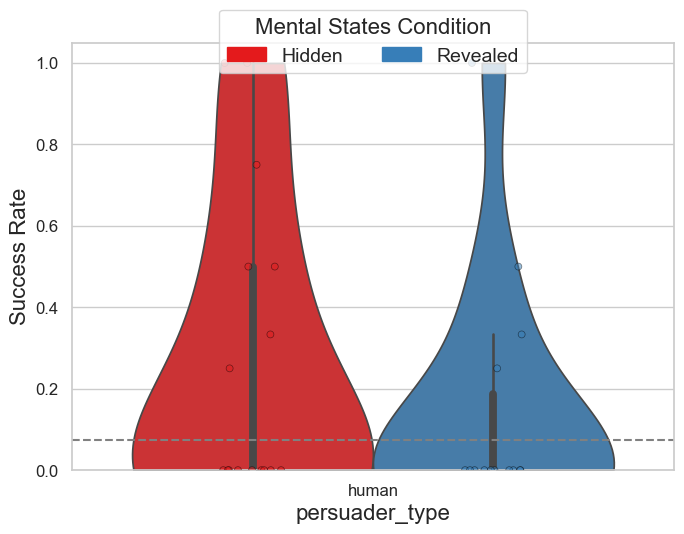

In [25]:
## A violin plot

create_plot(
    data=plot_data,
    # filename="human_violin_plot",
    order=["human"],
    use_violin=True,
)

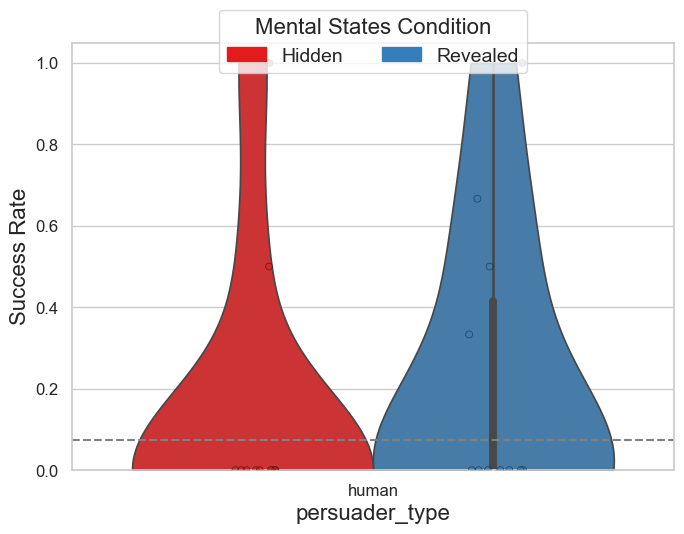

In [26]:
# Ignoring the first trial for all participants

create_plot(
    data=plot_data[plot_data["trial_num"] > 0],
    # filename="human_violin_plot_no_first_trial",
    order=["human"],
    use_violin=True,
)

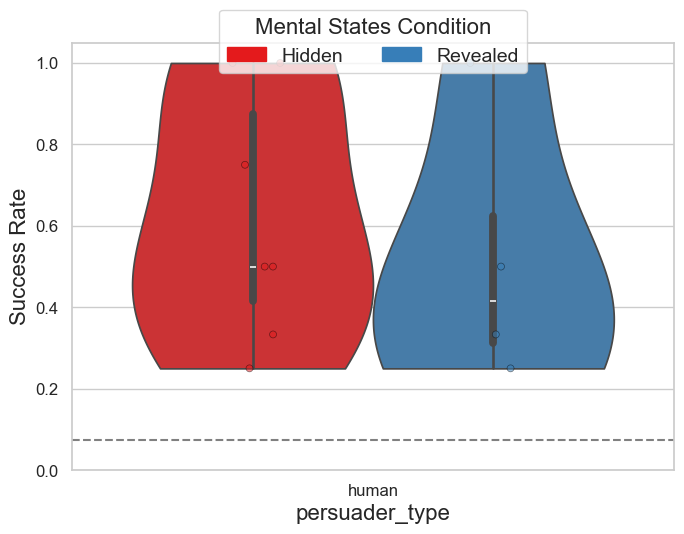

In [27]:
# Ignoring the humans who always fail

failed = (
    plot_data.groupby("persuader_id")[["persuader_id", "success"]]
    .apply(lambda grp: grp["success"].mean() == 0)
    .rename("failed")
)
failed_p_ids = failed[failed].index

no_failures = plot_data[
    (plot_data["persuader_type"] == "human")
    & (~plot_data["persuader_id"].isin(failed_p_ids))
]

create_plot(
    data=no_failures,
    filename=None,
    order=["human"],
    use_violin=True,
)

### By scenario

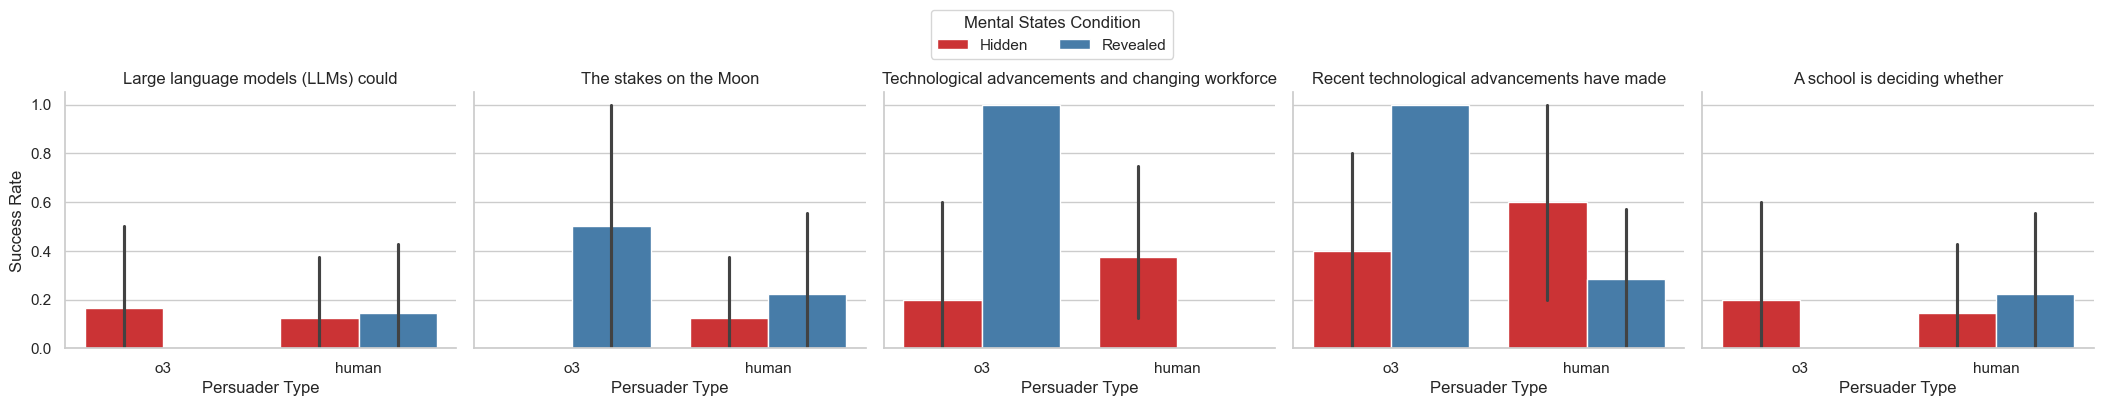

In [28]:
g = sns.catplot(
    data=plot_data,
    x="persuader_type",
    y="success",
    hue="mental_state",
    hue_order=["Hidden", "Revealed"],  # Specify the desired order
    col="scenario",
    kind="bar",
    errorbar=("ci", 95),
    palette="Set1",
    height=4,
    aspect=1,
)


g.set_axis_labels("Persuader Type", "Success Rate")
g.set_titles(col_template="{col_name}")

# Remove default legend and add to the top
g._legend.remove()
g.fig.legend(
    handles=g._legend_data.values(),
    labels=g._legend_data.keys(),
    title="Mental States Condition",
    loc="upper center",
    bbox_to_anchor=(0.5, 1.03),
    ncol=len(g._legend_data),
)


# 2) fix your x‐tick labels:
for ax in g.axes.flat:
    # grab the old text, replace '-' with a line break + '-'
    old = [t.get_text() for t in ax.get_xticklabels()]
    new = [s.replace("-", "\n-") for s in old]

    # set both ticks *and* labels so you do not get the 'fixed number of ticks' warning
    ticks = ax.get_xticks()
    ax.set_xticks(ticks)
    ax.set_xticklabels(new, ha="center", linespacing=0)

plt.tight_layout(rect=[0, 0, 1, 0.9])  # Make room for the legend


filename = "e2_by_scenario"
# plt.savefig(f"analysis/figures/{filename}.png")
# plt.savefig(f"analysis/figures/{filename}.pdf")

plt.show()

### Showing appeals

In [29]:
other_color_dict = {
    cond: color
    for color, cond in zip(
        sns.color_palette("Set1", n_colors=4)[2:], ["Hidden", "Revealed"]
    )
}

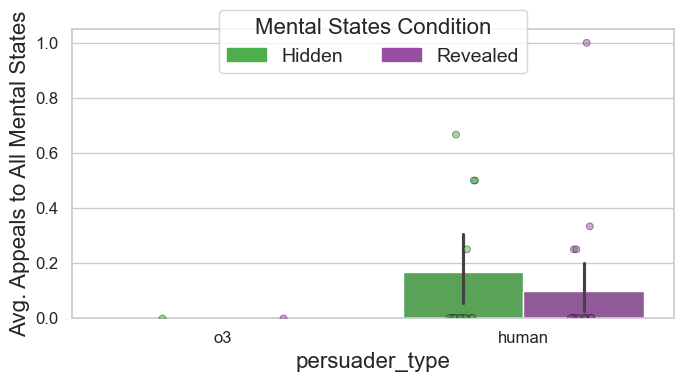

In [30]:
# Function to create and save plots
create_plot(
    plot_data,
    "e1_appeals",
    measure="appeals_success",
    ylabel="Avg. Appeals to All Mental States",
    colors=other_color_dict,
    figsize=(7, 4),
    ylim=(0, 1.05),
)

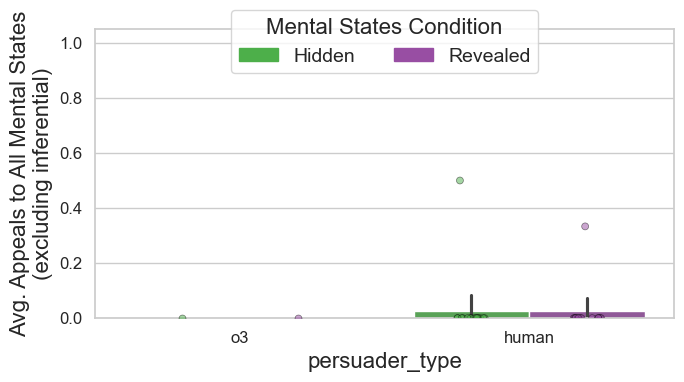

In [31]:
# Function to create and save plots
create_plot(
    plot_data,
    "e1_appeals_no_inferential",
    measure="appeals_success_no_inferential",
    ylabel="Avg. Appeals to All Mental States\n(excluding inferential)",
    colors=other_color_dict,
    figsize=(7, 4),
    ylim=(0, 1.05),
)

In [32]:
plot_data[
    (plot_data["persuader_type"] == "o1-preview")
    & (plot_data["mental_state"] == "Revealed")
]["appeals_success"].mean()

nan

In [33]:
plot_data[
    (plot_data["persuader_type"] == "human") & (plot_data["mental_state"] == "Revealed")
]["appeals_success"].mean()

np.float64(0.1)

## How do the number of disclosures revealed and appeals made change based on condition?

In [34]:
# todo; show this graph with reveal and no reveal conditions

In [35]:
def filter_disclosures_for_proposal(
    all_disclosures: list[dict[str, dict[str, int]]], chosen_proposal: str
) -> list[dict[str, dict[str, int]]]:
    """
    Returns the information revealed over the course of the game if it matches the chosen_proposal
    """
    result: list[dict[str, dict[str, int]]] = []
    for disclosures in all_disclosures:
        if chosen_proposal in disclosures:
            result.append({chosen_proposal: disclosures[chosen_proposal]})
        else:
            result.append({})
    return result

In [36]:
# Just focusing on the rational target conditions for now.
desired_conditions = list(
    filter(
        lambda c: not c.is_rational_target()
        and not c.add_hint
        and (c.roles.human_persuader or "o3" in c.roles.llm_persuader)
        and not c.discrete_game
        and not c.perfect_game
        and not c.reveal_belief
        and not c.non_mental
        and not c.reveal_motivation,
        list(conditions_to_games.keys()),
    )
)

In [37]:
# Create a dictionary mapping condition -> measures
condition_measures = {}

for condition in desired_conditions:

    games = list(itertools.chain(*conditions_to_games[condition]))
    # Only use games whose model is a solution
    games = list(filter(lambda g: g.model.is_solution(), games))

    # Initialize measure containers for disclosures and appeals.
    disclosures = {
        "new": {"all": [], "success": [], "failure": []},
        "ideal": {"all": [], "success": [], "failure": []},
        "persuader_preferred": {"all": [], "success": [], "failure": []},
        "total": {"all": [], "success": [], "failure": []},
    }

    appeals = {
        "new_informational": {"all": [], "success": [], "failure": []},
        "all_informational": {"all": [], "success": [], "failure": []},
        "new_motivational": {"all": [], "success": [], "failure": []},
        "all_motivational": {"all": [], "success": [], "failure": []},
    }

    # Process every game for this condition.
    for game in games:
        # ----------------------------
        # Process disclosures measures:
        # ----------------------------
        new_disc = [len_nested_dicts(d) for d in game.all_disclosures_no_repeats()]
        ideal_disc = [
            len_nested_dicts(d)
            for d in game.all_disclosures_no_repeats(ideal_revealed_only=True)
        ]
        preferred_disc = [
            len_nested_dicts(d)
            for d in filter_disclosures_for_proposal(
                game.all_disclosures, game.persuader_choice
            )
        ]
        all_disc = [len_nested_dicts(d) for d in game.all_disclosures]

        disclosures["new"]["all"].append(new_disc)
        disclosures["ideal"]["all"].append(ideal_disc)
        disclosures["persuader_preferred"]["all"].append(preferred_disc)
        disclosures["total"]["all"].append(all_disc)

        key = "success" if game.target_choice == game.persuader_choice else "failure"
        disclosures["new"][key].append(new_disc)
        disclosures["ideal"][key].append(ideal_disc)
        disclosures["persuader_preferred"][key].append(preferred_disc)
        disclosures["total"][key].append(all_disc)

        # --------------------------
        # Process appeals measures:
        # --------------------------
        appeals_no_repeats = game.all_appeals_no_repeats()
        # For informational, if the key doesn't exist, default to {}
        info_no_repeats = [
            appeal.get("informational", {}) for appeal in appeals_no_repeats
        ]
        # For motivational, if the key doesn't exist, default to []
        mot_no_repeats = [
            appeal.get("motivational", []) for appeal in appeals_no_repeats
        ]

        appeals_all = game.all_appeals
        info_all = [appeal.get("informational", {}) for appeal in appeals_all]
        mot_all = [appeal.get("motivational", []) for appeal in appeals_all]

        new_info_lengths = [len_nested_dicts(d) for d in info_no_repeats]
        all_info_lengths = [len_nested_dicts(d) for d in info_all]
        new_mot_lengths = [len(d) for d in mot_no_repeats]
        all_mot_lengths = [len(d) for d in mot_all]

        appeals["new_informational"]["all"].append(new_info_lengths)
        appeals["all_informational"]["all"].append(all_info_lengths)
        appeals["new_motivational"]["all"].append(new_mot_lengths)
        appeals["all_motivational"]["all"].append(all_mot_lengths)

        appeals["new_informational"][key].append(new_info_lengths)
        appeals["all_informational"][key].append(all_info_lengths)
        appeals["new_motivational"][key].append(new_mot_lengths)
        appeals["all_motivational"][key].append(all_mot_lengths)

    # Save the computed measures for this condition in the main dictionary.
    condition_measures[condition] = {
        "disclosures": disclosures,
        "appeals": appeals,
    }

##### disclosures

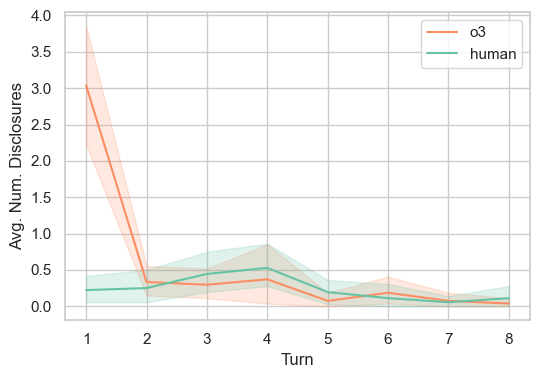

In [38]:
# New (all)

plot_measure_across_conditions_from_condition_measures(
    condition_measures,
    measure_type="disclosures",
    measure_key="new",
    outcome="all",
    palette=persuader_to_color,
    ylabel="Avg. Num. Disclosures",
    # filename="num_disclosures_by_turn_hidden",
)

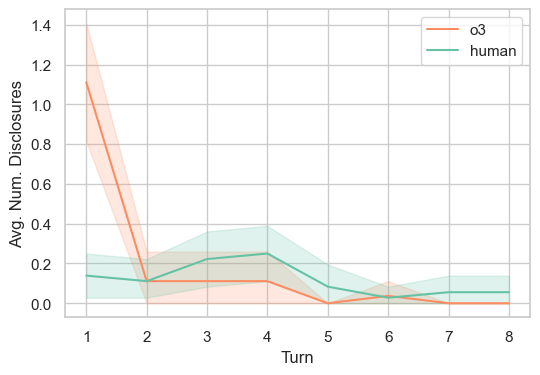

In [39]:
# ideal only

plot_measure_across_conditions_from_condition_measures(
    condition_measures,
    measure_type="disclosures",
    measure_key="ideal",
    outcome="all",
    palette=persuader_to_color,
    ylabel="Avg. Num. Disclosures",
)

##### appeals

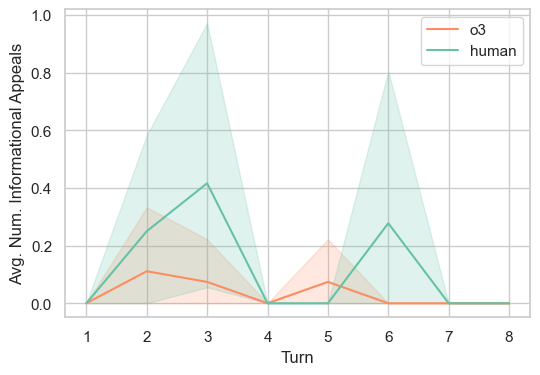

In [40]:
# all

plot_measure_across_conditions_from_condition_measures(
    condition_measures,
    measure_type="appeals",
    measure_key="all_informational",
    outcome="all",
    palette=persuader_to_color,
    ylabel="Avg. Num. Informational Appeals",
)

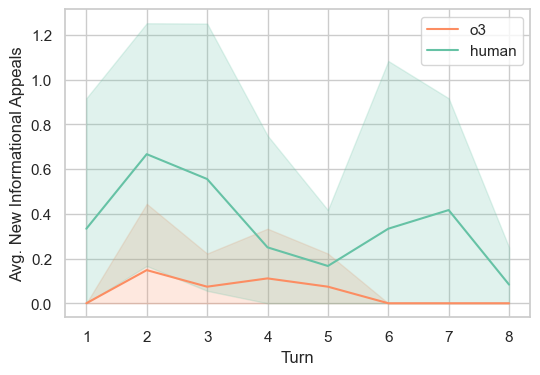

In [41]:
# new

plot_measure_across_conditions_from_condition_measures(
    condition_measures,
    measure_type="appeals",
    measure_key="new_informational",
    outcome="all",
    palette=persuader_to_color,
    ylabel="Avg. New Informational Appeals",
    # filename="num_informational_appeals_by_turn_hidden",
)

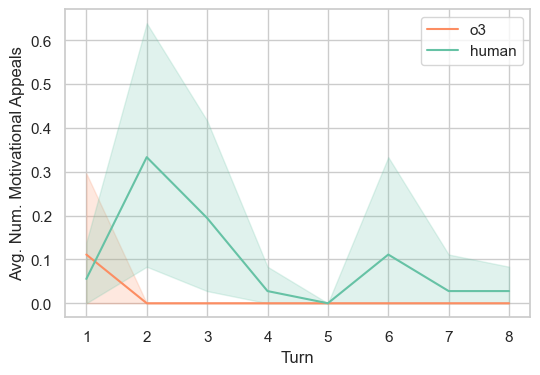

In [42]:
# all

plot_measure_across_conditions_from_condition_measures(
    condition_measures,
    measure_type="appeals",
    measure_key="all_motivational",
    outcome="all",
    palette=persuader_to_color,
    ylabel="Avg. Num. Motivational Appeals",
)

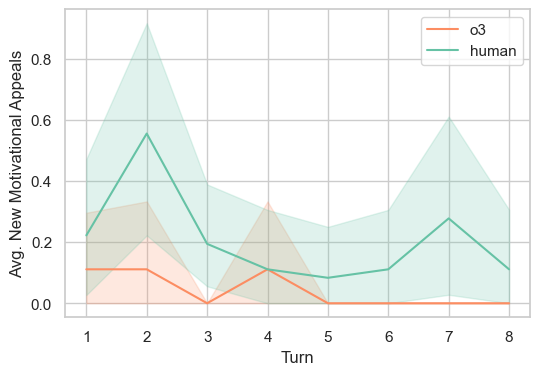

In [43]:
plot_measure_across_conditions_from_condition_measures(
    condition_measures,
    measure_type="appeals",
    measure_key="new_motivational",
    outcome="all",
    palette=persuader_to_color,
    ylabel="Avg. New Motivational Appeals",
    # filename="num_motivational_appeals_by_turn_hidden",
)

## Comparing LLM data